This code is used to compare the pulsar proper motions from timing and Gaia astrometry.

In [1]:
import numpy as np
from numpy import sqrt
from matplotlib import pyplot as plt

from matplotlib.ticker import MultipleLocator

from astropy.table import Table, join
from astropy import units as u

import seaborn as sns

from psrcrf_tools import *

# %config InlineBackend.figure_format = "svg"

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Read the timing solution data.

In [2]:
timing_table = Table.read("../data/timing_edr3.fits",)
timing_table.sort("psr_name")

Add unit information

In [3]:
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr

Load the cross-match table.

In [4]:
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.65.fits")
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.66.fits")
edr3_antf_table = Table.read("../data/edr3_psrcatv1.67.fits")

Only keep the astrometric parameters from Gaia.

In [5]:
edr3_antf_table = edr3_antf_table['name', 'source_id', 'pmra', 'pmra_error',
                                  'pmdec', 'pmdec_error', ]

edr3_antf_table.rename_columns(["name", "pmra_error", "pmdec_error"],
                               ["psr_name", "pmra_err", "pmdec_err"])

Add unit information

In [6]:
edr3_antf_table["pmra"].unit = u.mas / u.yr
edr3_antf_table["pmdec"].unit = u.mas / u.yr
edr3_antf_table["pmra_err"].unit = u.mas / u.yr
edr3_antf_table["pmdec_err"].unit = u.mas / u.yr

Supplement the timing table with the Gaia astrometrical information.

In [7]:
edr3_timing = join(timing_table,
                   edr3_antf_table,
                   keys="psr_name",
                   join_type="left",
                   table_names=["t", "g"])

Remove pulsars that do not have proper motion information in Gaia EDR3.

In [8]:
mask = (edr3_timing["pmra_g"] < 1e10)
edr3_timing = edr3_timing[mask]

Remove entries without timing PM estimate, i.e., the corresponding uncertainty is 0.

In [9]:
pm_tab = edr3_timing[edr3_timing["pmra_err_t"] != 0]

Then compute the proper motion differences in RA and declination.

In [11]:
dpmra = pm_tab["pmra_t"] - pm_tab["pmra_g"]
dpmdec = pm_tab["pmdec_t"] - pm_tab["pmdec_g"]

dpmra_err = sqrt(pm_tab["pmra_err_t"]**2 + pm_tab["pmra_err_g"]**2)
dpmdec_err = sqrt(pm_tab["pmdec_err_t"]**2 + pm_tab["pmdec_err_g"]**2)

X_pmra = dpmra / dpmra_err
X_pmdec = dpmdec / dpmdec_err

pm_tab.add_columns([dpmra, dpmdec, dpmra_err, dpmdec_err, X_pmra, X_pmdec], names=[
                   "dpmra", "dpmdec", "dpmra_err", "dpmdec_err", "X_pmra", "X_pmdec"])

In [12]:
count_psr_nb(pm_tab)

There are 11 pulsars with 40 measurements.


Divide entries into several subsets.

## DE200 vs. Gaia EDR3

In [13]:
mask = pm_tab["eph"] == "DE200"
pm_tab200 = pm_tab[mask]

pm_tab200

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra_t,pmdec_t,plx,ra_err,dec_err,pmra_err_t,pmdec_err_t,plx_err,ref,comment,source_id,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dpmra,dpmdec,dpmra_err,dpmdec_err,X_pmra,X_pmdec
,,d,,,,mas / yr,mas / yr,,,,mas / yr,mas / yr,,,,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0437-4715,J0437-4715,49615.0,DE200,69.31556254166667,-47.25226463888889,121.3,-70.4,1.0,0.20363151618244418,0.2,0.2,0.30000000000000004,5.0,bbm+97,,4789864076732331648,121.646,0.574,-70.697,0.65,-0.34600000000000364,0.29699999999999704,0.6078453750749445,0.7158910531638177,-0.5692237108118877,0.4148675956871253
J1012+5307,J1012+5307,50914.0,DE200,153.13930791666667,53.11738166666667,2.3,-25.8,0.0,1.8005327985444117,2.0,0.7,0.8,0.0,hlk+04,,851610861391010944,2.736,0.292,-25.921,0.271,-0.4360000000000004,0.12099999999999866,0.7584616008737686,0.8446543671822221,-0.5748478228795187,0.1432538618176524
J1012+5307,J1012+5307,50700.0,DE200,153.1393070833333,53.117385666666664,2.4,-25.2,0.0,0.2700798946531054,0.4,0.2,0.2,0.0,lcw+01,,851610861391010944,2.736,0.292,-25.921,0.271,-0.3360000000000003,0.7210000000000001,0.3539265460515783,0.3368100354799423,-0.9493495295801702,2.140672557373775
J1024-0719,J1024-0719,50456.0,DE200,156.16126666666665,-7.3219025,-41.0,-70.0,0.0,1.48776869555416,3.0,2.0,3.0,0.0,tsb+99,,3775277872387310208,-35.458,0.318,-48.352,0.357,-5.542000000000002,-21.648000000000003,2.0251232061284568,3.021166827568448,-2.7366236203450347,-7.165443431478145
J1024-0719,J1024-0719,51018.0,DE200,156.16125125,-7.321920833333333,-35.0,-48.0,0.0,5.95107453754186,15.0,4.0,8.0,0.0,hlk+04,,3775277872387310208,-35.458,0.318,-48.352,0.357,0.4579999999999984,0.35199999999999676,4.012620590088228,8.007961600807036,0.11413987186611332,0.04395625473085716
B1848+12,J1851+1259,49908.0,DE200,282.8050625,12.993133333333333,-23.0,-71.0,0.0,58.46382103552277,140.0,17.0,35.0,0.0,hlk+04,,4504706118346043392,-3.564,1.186,-7.612,1.247,-19.436,-63.388,17.04132025401788,35.022207369039435,-1.1405219613437827,-1.809937315831117
B1953+29,J1955+2908,49718.0,DE200,298.86614875,29.145425,-1.0,-3.7,0.0,2.6201591222646075,2.0,0.30000000000000004,0.30000000000000004,0.0,wdk+00,,2028584968839606784,-3.167,0.135,-7.827,0.167,2.167,4.127,0.3289756829919197,0.3433496759864497,6.5871130057148495,12.019816206737506
B1953+29,J1955+2908,49429.0,DE200,298.8661583333334,29.145425,-2.0,-2.0,0.0,26.201591222646073,40.0,9.0,10.0,0.0,hlk+04,,2028584968839606784,-3.167,0.135,-7.827,0.167,1.1669999999999998,5.827,9.00101244305328,10.001394352789015,0.1296520816278458,0.5826187623903728


## DE405 vs. Gaia EDR3

In [14]:
mask = pm_tab["eph"] == "DE405"
pm_tab405 = pm_tab[mask]

pm_tab405

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra_t,pmdec_t,plx,ra_err,dec_err,pmra_err_t,pmdec_err_t,plx_err,ref,comment,source_id,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dpmra,dpmdec,dpmra_err,dpmdec_err,X_pmra,X_pmdec
,,d,,,,mas / yr,mas / yr,,,,mas / yr,mas / yr,,,,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0437-4715,J0437-4715,53019.0,DE405,69.31603281125,-47.252450716666665,121.31,-71.53,0.0,0.008145232028164005,0.008,0.01,0.01,0.0,hbo06,,4789864076732331648,121.646,0.574,-70.697,0.65,-0.3359999999999985,-0.8329999999999984,0.5740871014053529,0.6500769185258003,-0.5852770410230046,-1.2813868270988893
J1012+5307,J1012+5307,50700.0,DE405,153.13930875416665,53.117389083333336,2.562,-25.61,1.22,0.08912635815241264,0.13,0.014,0.02,0.26,lwj+09,,851610861391010944,2.736,0.292,-25.921,0.271,-0.17400000000000038,0.31099999999999994,0.29233542378576016,0.2717370052090808,-0.5952066901324875,1.1444889508541882
J1024-0719,J1024-0719,53000.0,DE405,156.16120191666664,-7.3219916666666665,-35.3,-48.2,0.0,0.44633051941513135,1.0,0.2,0.30000000000000004,0.0,vbc+09,,3775277872387310208,-35.458,0.318,-48.352,0.357,0.15800000000000125,0.15199999999999392,0.37566474415361367,0.46631427170954143,0.4205877779560629,0.32596042888147314
J1024-0719,J1024-0719,53000.0,DE405,156.161201875,-7.321991722222222,-34.9,-47.0,0.0,0.29755367957301526,0.6000000000000001,0.4,1.0,0.0,hbo06,,3775277872387310208,-35.458,0.318,-48.352,0.357,0.5579999999999998,1.3519999999999968,0.5110029354123125,1.061814013846116,1.0919702438690824,1.2732926693091622
B1953+29,J1955+2908,54500.0,DE405,298.86615,29.145407194444445,-0.9,-4.1,0.0,0.3930239364478579,0.5,0.1,0.1,0.0,gsf+11,,2028584968839606784,-3.167,0.135,-7.827,0.167,2.267,3.7270000000000003,0.16800297616411444,0.1946509696867704,13.493808572685468,19.14709187422717


## DE421 vs. Gaia EDR3

In [15]:
mask = pm_tab["eph"] == "DE421"
pm_tab421 = pm_tab[mask]

pm_tab421

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra_t,pmdec_t,plx,ra_err,dec_err,pmra_err_t,pmdec_err_t,plx_err,ref,comment,source_id,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dpmra,dpmdec,dpmra_err,dpmdec_err,X_pmra,X_pmdec
,,d,,,,mas / yr,mas / yr,,,,mas / yr,mas / yr,,,,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0348+0432,J0348+0432,56000.0,DE421,57.18182916666666,4.536516111111111,4.04,3.5,0.0,0.05981202763317285,0.2,0.16,0.6000000000000001,0.0,afw+13,,3273288485744249344,3.438,1.345,-0.226,0.887,0.6019999999999999,3.726,1.354483296316348,1.0708730083441267,0.44444992539752887,3.4794041599399845
J0437-4715,J0437-4715,54500.0,DE421,69.3162340571,-47.2525307528,121.439,-71.475,6.373,0.00602974,0.00626552,0.001915,0.001954,0.086288,rhc+16,PPTA-DR1e,4789864076732331648,121.646,0.574,-70.697,0.65,-0.20700000000000784,-0.7779999999999916,0.5740031944379752,0.6500029370056724,-0.36062517074088435,-1.1969176686861682
J0437-4715,J0437-4715,54500.0,DE421,69.3162340617,-47.2525307528,121.441,-71.475,6.441,0.00373391,0.00383898,0.001714,0.001865,0.074791,vlh+16,IPTA-DR1,4789864076732331648,121.646,0.574,-70.697,0.65,-0.2049999999999983,-0.7779999999999916,0.5740025590500446,0.6500026755521857,-0.3571412649087603,-1.1969181501277213
J1012+5307,J1012+5307,55000.0,DE421,153.1393230512,53.1173055972,2.627,-25.458,0.782,0.05085026,0.06366704,0.010222,0.013951,0.193807,vlh+16,IPTA-DR1,851610861391010944,2.736,0.292,-25.921,0.271,-0.10900000000000043,0.46300000000000097,0.29217886522471126,0.2713588590796328,-0.37305915305054604,1.706227692622076
J1012+5307,J1012+5307,54902.0,DE421,153.1393227083333,53.117307527777776,2.5,-25.6,1.0,0.5401607710644697,0.7000000000000001,0.2,0.2,3.0,mnf+16,NANOGrav-9yr,851610861391010944,2.736,0.292,-25.921,0.271,-0.2360000000000002,0.32099999999999795,0.3539265460515783,0.3368100354799423,-0.666805026728929,0.9530594880956691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J1431-4715,J1431-4715,55756.1,DE421,217.93590708333332,-47.25765944444444,-7.0,-8.0,0.0,2.036107720142993,4.0,3.0,4.0,0.0,btb+15,,6098156298150016768,-11.825,0.135,-14.519,0.15,4.824999999999999,6.519,3.003035963820613,4.002811511925087,1.6067073648566605,1.6286052892020373
J1816+4510,J1816+4510,56047.0,DE421,274.14972649999993,45.17607272222222,5.3,-3.0,0.0,0.7401769957990335,0.8,0.8,1.0,0.0,slr+14,,2115337192179377792,-0.059,0.123,-4.4,0.117,5.359,1.4000000000000004,0.8094003953544872,1.0068212353739863,6.620950558904728,1.390514970097911


## DE430 vs. Gaia EDR3

In [16]:
mask = pm_tab["eph"] == "DE430"
pm_tab430 = pm_tab[mask]

pm_tab430

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra_t,pmdec_t,plx,ra_err,dec_err,pmra_err_t,pmdec_err_t,plx_err,ref,comment,source_id,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dpmra,dpmdec,dpmra_err,dpmdec_err,X_pmra,X_pmdec
,,d,,,,mas / yr,mas / yr,,,,mas / yr,mas / yr,,,,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0437-4715,J0437-4715,57600.0,DE430,69.316656,-47.252699166666666,121.48,-71.43,0.0,0.10181492269904993,0.1,0.02,0.01,0.0,jbs+19,UTMOST-I,4789864076732331648,121.646,0.574,-70.697,0.65,-0.16599999999999682,-0.7330000000000041,0.5743483263665004,0.6500769185258003,-0.28902321531980874,-1.1275588766668583
B1813-36,J1817-3618,57600.0,DE430,274.2744041666667,-36.30127777777778,19.0,-16.0,0.0,108.79853570658419,300.0,5.0,17.0,0.0,jbs+19,UTMOST-I,4038146565444090240,-3.162,0.148,-6.092,0.109,22.162,-9.908000000000001,5.002189920424853,17.0003494375851,4.430459529237088,-0.582811549631737


## DE436 vs. Gaia EDR3

In [17]:
mask = pm_tab["eph"] == "DE436"
pm_tab436 = pm_tab[mask]

pm_tab436

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra_t,pmdec_t,plx,ra_err,dec_err,pmra_err_t,pmdec_err_t,plx_err,ref,comment,source_id,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dpmra,dpmdec,dpmra_err,dpmdec_err,X_pmra,X_pmdec
,,d,,,,mas / yr,mas / yr,,,,mas / yr,mas / yr,,,,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0437-4715,J0437-4715,55000.0,DE436,69.3163022208,-47.2525579444,121.443,-71.474,6.418,0.00503983,0.00530447,0.001435,0.00156,0.067263,pdd+19,IPTA-DR2,4789864076732331648,121.646,0.574,-70.697,0.65,-0.20300000000000296,-0.777000000000001,0.5740017937471973,0.6500018719973044,-0.3536574314076247,-1.195381172691797
J1012+5307,J1012+5307,55291.0,DE436,153.139324,53.11730002777778,2.66,-25.5,1.3,0.09002681088274288,0.1,0.03,0.04,0.4,abb+18,NANOGrav-11yr,851610861391010944,2.736,0.292,-25.921,0.271,-0.07600000000000007,0.4209999999999994,0.29353705047233813,0.27393612394133054,-0.2589110978587081,1.5368546285270714
J1012+5307,J1012+5307,55000.0,DE436,153.1393230429,53.1173056083,2.614,-25.486,0.933,0.04953387,0.06394984,0.010224,0.013773,0.192303,pdd+19,IPTA-DR2,851610861391010944,2.736,0.292,-25.921,0.271,-0.12200000000000033,0.4349999999999987,0.29217893520238586,0.271349766038226,-0.4175523465286559,1.6030970151590944
J1024-0719,J1024-0719,55636.0,DE436,156.1611309125,-7.322087388888889,-35.27,-48.22,0.83,0.059510723146806305,0.1,0.017,0.03,0.13,rsc+21,PPTA-DR2e,3775277872387310208,-35.458,0.318,-48.352,0.357,0.18799999999999528,0.1319999999999979,0.31845407832213424,0.35825828671504584,0.5903519935763633,0.3684492582442037
J1024-0719,J1024-0719,56239.0,DE436,156.16111399166664,-7.3221103888888885,-35.29,-48.2,0.8,0.08926608011575785,0.2,0.06,0.1,0.2,abb+18,NANOGrav-11yr,3775277872387310208,-35.458,0.318,-48.352,0.357,0.16799999999999926,0.15199999999999392,0.3236108774438832,0.37074114959092414,0.5191420057539068,0.4099895578565011
J1024-0719,J1024-0719,55000.0,DE436,156.1611475046,-7.3220649306,-35.267,-48.225,0.822,0.04801056,0.09847672,0.017593,0.036161,0.102243,pdd+19,IPTA-DR2,3775277872387310208,-35.458,0.318,-48.352,0.357,0.1909999999999954,0.12699999999999534,0.31848628486796726,0.3588267240897757,0.5997118528327743,0.3539312751082077
B1953+29,J1955+2908,56568.0,DE436,298.86614760000003,29.145400416666668,-1.1,-4.2,0.0,0.11790718871207326,0.2,0.1,0.2,1.0,abb+18,NANOGrav-11yr,2028584968839606784,-3.167,0.135,-7.827,0.167,2.0669999999999997,3.627,0.16800297616411444,0.2605551764981844,12.303353471433992,13.92027611481852
B1953+29,J1955+2908,55000.0,DE436,298.8661490629,29.1454053639,-1.029,-4.171,-1.178,0.17596624,0.24031268,0.055342,0.078402,1.098837,pdd+19,IPTA-DR2,2028584968839606784,-3.167,0.135,-7.827,0.167,2.138,3.6559999999999997,0.14590317667549257,0.1844881394670129,14.653553464124958,19.816992087199758


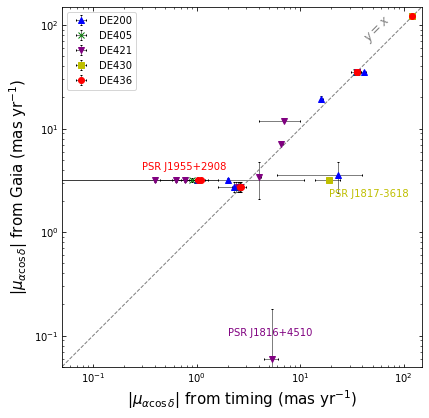

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(np.fabs(pm_tab200["pmra_t"]),
            np.fabs(pm_tab200["pmra_g"]),
            xerr=pm_tab200["pmra_err_t"],
            yerr=pm_tab200["pmra_err_g"],
            fmt="b^",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE200")

ax.errorbar(np.fabs(pm_tab405["pmra_t"]),
            np.fabs(pm_tab405["pmra_g"]),
            xerr=pm_tab405["pmra_err_t"],
            yerr=pm_tab405["pmra_err_g"],
            fmt="gx",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE405")

ax.errorbar(np.fabs(pm_tab421["pmra_t"]),
            np.fabs(pm_tab421["pmra_g"]),
            xerr=pm_tab421["pmra_err_t"],
            yerr=pm_tab421["pmra_err_g"],
            fmt="v",
            color="purple",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE421")

ax.errorbar(np.fabs(pm_tab430["pmra_t"]),
            np.fabs(pm_tab430["pmra_g"]),
            xerr=pm_tab430["pmra_err_t"],
            yerr=pm_tab430["pmra_err_g"],
            fmt="ys",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE430")

ax.errorbar(np.fabs(pm_tab436["pmra_t"]),
            np.fabs(pm_tab436["pmra_g"]),
            xerr=pm_tab436["pmra_err_t"],
            yerr=pm_tab436["pmra_err_g"],
            fmt="ro",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE436")

x = np.arange(0.01, 250, 5)
ax.plot(x, x, "--", color="tab:grey", lw=1)
ax.text(40, 70, "$y=x$", rotation=45, color="tab:grey", fontsize=12)

ax.text(2.0, 0.1, "PSR J1816+4510", color="purple")
ax.text(19, 2.2, "PSR J1817-3618", color="y")
ax.text(0.3, 4, "PSR J1955+2908", color="r")

ax.set_yscale("log")
ax.set_xscale("log")
ax.axis("square")
ax.axis([0.05, 150, 0.05, 150])

ax.set_xlabel("$|\mu_{\\alpha\cos\delta}|$ from timing (mas yr$^{-1}$)",
              fontsize=15)
ax.set_ylabel("$|\mu_{\\alpha\cos\delta}|$ from Gaia (mas yr$^{-1}$)",
              fontsize=15)

# plt.grid(lw=1)
plt.tight_layout()
plt.legend(loc="upper left")

# plt.savefig("../plots/gedr3_pmra-com.eps")

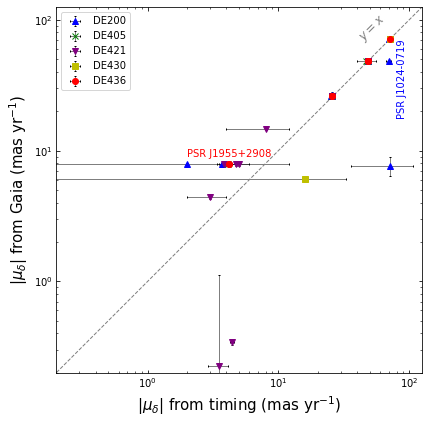

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(np.fabs(pm_tab200["pmdec_t"]),
            np.fabs(pm_tab200["pmdec_g"]),
            xerr=pm_tab200["pmdec_err_t"],
            yerr=pm_tab200["pmdec_err_g"],
            fmt="b^",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE200")

ax.errorbar(np.fabs(pm_tab405["pmdec_t"]),
            np.fabs(pm_tab405["pmdec_g"]),
            xerr=pm_tab405["pmdec_err_t"],
            yerr=pm_tab405["pmdec_err_g"],
            fmt="gx",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE405")

ax.errorbar(np.fabs(pm_tab421["pmdec_t"]),
            np.fabs(pm_tab421["pmdec_g"]),
            xerr=pm_tab421["pmdec_err_t"],
            yerr=pm_tab421["pmdec_err_g"],
            fmt="v",
            color="purple",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE421")

ax.errorbar(np.fabs(pm_tab430["pmdec_t"]),
            np.fabs(pm_tab430["pmdec_g"]),
            xerr=pm_tab430["pmdec_err_t"],
            yerr=pm_tab430["pmdec_err_g"],
            fmt="ys",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE430")

ax.errorbar(np.fabs(pm_tab436["pmdec_t"]),
            np.fabs(pm_tab436["pmdec_g"]),
            xerr=pm_tab436["pmdec_err_t"],
            yerr=pm_tab436["pmdec_err_g"],
            fmt="ro",
            ecolor="k",
            elinewidth=0.5,
            capsize=1,
            label="DE436")

x = np.arange(0.01, 250, 5)
ax.plot(x, x, "--", color="tab:grey", lw=1)
ax.text(40, 70, "$y=x$", rotation=45, color="tab:grey", fontsize=12)

ax.text(80, 18, "PSR J1024-0719", color="b", rotation="vertical")
ax.text(2, 9, "PSR J1955+2908", color="r")


ax.set_yscale("log")
ax.set_xscale("log")
ax.axis("square")
ax.axis([0.2, 125, 0.2, 125])

ax.set_xlabel("$|\mu_{\delta}|$ from timing (mas yr$^{-1}$)", fontsize=15)
ax.set_ylabel("$|\mu_{\delta}|$ from Gaia (mas yr$^{-1}$)", fontsize=15)

# plt.grid(lw=1)
plt.tight_layout()
plt.legend(loc="upper left")

# plt.savefig("../plots/gedr3_pmdec-com.eps")

Compute the PM differences.

In [20]:
pm_tab[pm_tab["psr_name"] == "J0348+0432"]["psr_name",
                                           "eph", "pmra_g", "dpmra", "X_pmra", "pmdec_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,dpmra,X_pmra,pmdec_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J0348+0432,DE421,3.438,0.6019999999999999,0.44444992539752887,-0.226,3.726,3.4794041599399845,afw+13


In [21]:
pm_tab[pm_tab["psr_name"] == "J0437-4715"]["psr_name",
                                           "eph", "pmra_g", "dpmra", "X_pmra", "pmdec_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,dpmra,X_pmra,pmdec_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J0437-4715,DE421,121.646,-0.20700000000000784,-0.36062517074088435,-70.697,-0.7779999999999916,-1.1969176686861682,rhc+16
J0437-4715,DE430,121.646,-0.16599999999999682,-0.28902321531980874,-70.697,-0.7330000000000041,-1.1275588766668583,jbs+19
J0437-4715,DE421,121.646,-0.2049999999999983,-0.3571412649087603,-70.697,-0.7779999999999916,-1.1969181501277213,vlh+16
J0437-4715,DE405,121.646,-0.3359999999999985,-0.5852770410230046,-70.697,-0.8329999999999984,-1.2813868270988893,hbo06
J0437-4715,DE200,121.646,-0.34600000000000364,-0.5692237108118877,-70.697,0.29699999999999704,0.4148675956871253,bbm+97
J0437-4715,DE436,121.646,-0.20300000000000296,-0.3536574314076247,-70.697,-0.777000000000001,-1.195381172691797,pdd+19


In [22]:
pm_tab[pm_tab["psr_name"] == "J1012+5307"]["psr_name",
                                           "eph", "pmra_g", "dpmra", "X_pmra", "pmdec_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,dpmra,X_pmra,pmdec_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J1012+5307,DE436,2.736,-0.07600000000000007,-0.2589110978587081,-25.921,0.4209999999999994,1.5368546285270714,abb+18
J1012+5307,DE421,2.736,-0.10900000000000043,-0.37305915305054604,-25.921,0.46300000000000097,1.706227692622076,vlh+16
J1012+5307,DE200,2.736,-0.4360000000000004,-0.5748478228795187,-25.921,0.12099999999999866,0.1432538618176524,hlk+04
J1012+5307,DE436,2.736,-0.12200000000000033,-0.4175523465286559,-25.921,0.4349999999999987,1.6030970151590944,pdd+19
J1012+5307,DE405,2.736,-0.17400000000000038,-0.5952066901324875,-25.921,0.31099999999999994,1.1444889508541882,lwj+09
J1012+5307,DE421,2.736,-0.2360000000000002,-0.666805026728929,-25.921,0.32099999999999795,0.9530594880956691,mnf+16
J1012+5307,DE421,2.736,-0.12700000000000022,-0.43476836674348307,-25.921,0.43900000000000006,1.6185933661436656,dcl+16
J1012+5307,DE200,2.736,-0.3360000000000003,-0.9493495295801702,-25.921,0.7210000000000001,2.140672557373775,lcw+01


In [23]:
pm_tab[pm_tab["psr_name"] == "J1024-0719"]["psr_name",
                                           "eph", "pmra_g", "dpmra", "X_pmra", "pmdec_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,dpmra,X_pmra,pmdec_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J1024-0719,DE421,-35.458,0.12699999999999534,0.39629688512051797,-48.352,0.03399999999999892,0.09296254329200228,rhc+16
J1024-0719,DE421,-35.458,0.17799999999999727,0.557274061267622,-48.352,0.17199999999999704,0.4727898177716195,dcl+16
J1024-0719,DE436,-35.458,0.18799999999999528,0.5903519935763633,-48.352,0.1319999999999979,0.3684492582442037,rsc+21
J1024-0719,DE405,-35.458,0.15800000000000125,0.4205877779560629,-48.352,0.15199999999999392,0.32596042888147314,vbc+09
J1024-0719,DE200,-35.458,-5.542000000000002,-2.7366236203450347,-48.352,-21.648000000000003,-7.165443431478145,tsb+99
J1024-0719,DE200,-35.458,0.4579999999999984,0.11413987186611332,-48.352,0.35199999999999676,0.04395625473085716,hlk+04
J1024-0719,DE405,-35.458,0.5579999999999998,1.0919702438690824,-48.352,1.3519999999999968,1.2732926693091622,hbo06
J1024-0719,DE421,-35.458,0.25799999999999557,0.7739551119052132,-48.352,0.35199999999999676,0.8602038546459445,mnf+16


In [24]:
pm_tab[pm_tab["psr_name"] == "J1302-6350"]["psr_name",
                                           "eph", "pmra_g", "dpmra", "X_pmra", "pmdec_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,dpmra,X_pmra,pmdec_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J1302-6350,DE421,-7.093,0.4930000000000003,2.732822682351714,-0.342,-4.058000000000001,-28.84186369908669,sjm14


In [25]:
pm_tab[pm_tab["psr_name"] == "J1431-4715"]["psr_name",
                                           "eph", "pmra_g", "dpmra", "X_pmra", "pmdec_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,dpmra,X_pmra,pmdec_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J1431-4715,DE421,-11.825,4.824999999999999,1.6067073648566605,-14.519,6.519,1.6286052892020373,btb+15


In [26]:
pm_tab[pm_tab["psr_name"] == "J1816+4510"]["psr_name",
                                          "eph", "pmra_g", "pmra_err_g", "dpmra", "X_pmra", "pmdec_g", "pmdec_err_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,pmra_err_g,dpmra,X_pmra,pmdec_g,pmdec_err_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,bytes6
J1816+4510,DE421,-0.059,0.123,5.359,6.620950558904728,-4.4,0.117,1.4000000000000004,1.390514970097911,slr+14


In [27]:
pm_tab[pm_tab["psr_name"] == "J1817-3618"]["psr_name",
                                           "eph", "pmra_g", "pmra_err_g", "dpmra", "X_pmra", "pmdec_g", "pmdec_err_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,pmra_err_g,dpmra,X_pmra,pmdec_g,pmdec_err_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,bytes6
J1817-3618,DE430,-3.162,0.148,22.162,4.430459529237088,-6.092,0.109,-9.908000000000001,-0.582811549631737,jbs+19


In [28]:
pm_tab[pm_tab["psr_name"] == "J1851+1259"]["psr_name",
                                           "eph", "pmra_g", "dpmra", "X_pmra", "pmdec_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,dpmra,X_pmra,pmdec_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J1851+1259,DE200,-3.564,-19.436,-1.1405219613437827,-7.612,-63.388,-1.809937315831117,hlk+04


In [29]:
pm_tab[pm_tab["psr_name"] == "J1955+2908"]["psr_name",
                                           "eph", "pmra_g", "dpmra", "X_pmra", "pmdec_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,dpmra,X_pmra,pmdec_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J1955+2908,DE436,-3.167,2.0669999999999997,12.303353471433992,-7.827,3.627,13.92027611481852,abb+18
J1955+2908,DE421,-3.167,2.767,2.2913787931761704,-7.827,2.827,2.788384752531372,mnf+16
J1955+2908,DE421,-3.167,2.529,10.557252793775001,-7.827,4.0169999999999995,11.29601983505385,vlh+16
J1955+2908,DE421,-3.167,2.397,10.284144413759254,-7.827,3.127,9.107333481576976,dcl+16
J1955+2908,DE405,-3.167,2.267,13.493808572685468,-7.827,3.7270000000000003,19.14709187422717,gsf+11
J1955+2908,DE436,-3.167,2.138,14.653553464124958,-7.827,3.6559999999999997,19.816992087199758,pdd+19
J1955+2908,DE200,-3.167,2.167,6.5871130057148495,-7.827,4.127,12.019816206737506,wdk+00
J1955+2908,DE200,-3.167,1.1669999999999998,0.1296520816278458,-7.827,5.827,0.5826187623903728,hlk+04


In [30]:
pm_tab[pm_tab["psr_name"] == "J1959+2048"]["psr_name",
                                           "eph", "pmra_g", "dpmra", "X_pmra", "pmdec_g", "dpmdec", "X_pmdec", "ref"]

psr_name,eph,pmra_g,dpmra,X_pmra,pmdec_g,dpmdec,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J1959+2048,DE200,-19.267,3.2669999999999995,2.4520110997787126,-26.56,0.759999999999998,0.5502717542553456,aft94


Compute the significance of differences in proper motions.

In [31]:
np.unique(pm_tab["psr_name"])

J0348+0432
J0437-4715
J1012+5307
J1024-0719
J1302-6350
J1431-4715
J1816+4510
J1817-3618
J1851+1259
J1955+2908
J1959+2048


In [32]:
edr3_timing_pm = edr3_timing[(edr3_timing["pmra_err_t"] != 0)
                             & (edr3_timing["pmdec_err_t"] != 0)]
# 36 data points
count_psr_nb(edr3_timing_pm)

There are 11 pulsars with 40 measurements.


<Figure size 432x288 with 0 Axes>

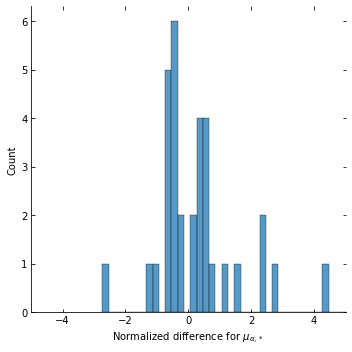

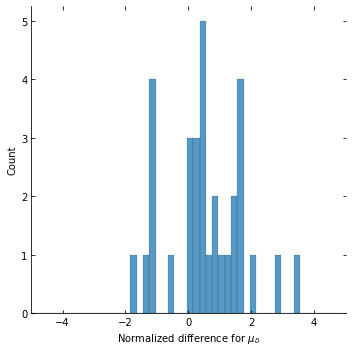

In [33]:
plt.clf()
sns.displot(
    X_pmra,
    binwidth=0.2, height=5, facet_kws=dict(margin_titles=True),
)
plt.xlim([-5, 5])
plt.xlabel("Normalized difference for $\mu_{\\alpha,*}$")
plt.tight_layout()

sns.displot(
    X_pmdec,
    binwidth=0.2, height=5, facet_kws=dict(margin_titles=True),
)
plt.xlim([-5, 5])
plt.xlabel("Normalized difference for $\mu_{\delta}$")
plt.tight_layout()

In [34]:
print("N      RA     DEC")
print("sigma  %      %")
for i in range(1, 11):
    per_ra = count_sigma(X_pmra, i)
    per_dec = count_sigma(X_pmdec, i)

    print("{:2d}     {:2.0f}     {:2.0f}".format(i, per_ra, per_dec))

N      RA     DEC
sigma  %      %
 1     62     38
 2     70     72
 3     80     78
 4     80     80
 5     82     80
 6     82     80
 7     88     80
 8     88     82
 9     88     82
10     88     85


$X_{\alpha,*} \ge 3$, or $X_{\delta} \ge 3$ suggests that the proper motion differences are statistically significant.

In [35]:
print("X_ra >= 3")

mask = np.fabs(X_pmra) >= 3
tmp = pm_tab[mask]["psr_name", "eph", "pmra_t",
                   "pmra_err_t", "pmra_g", "pmra_err_g", "dpmra", "X_pmra", "ref"]
tmp.sort("X_pmra")
tmp

X_ra >= 3


psr_name,eph,pmra_t,pmra_err_t,pmra_g,pmra_err_g,dpmra,X_pmra,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,float64,bytes6
J1817-3618,DE430,19.0,5.0,-3.162,0.148,22.162,4.430459529237088,jbs+19
J1955+2908,DE200,-1.0,0.30000000000000004,-3.167,0.135,2.167,6.5871130057148495,wdk+00
J1816+4510,DE421,5.3,0.8,-0.059,0.123,5.359,6.620950558904728,slr+14
J1955+2908,DE421,-0.77,0.19,-3.167,0.135,2.397,10.284144413759254,dcl+16
J1955+2908,DE421,-0.638,0.197888,-3.167,0.135,2.529,10.557252793775001,vlh+16
J1955+2908,DE436,-1.1,0.1,-3.167,0.135,2.0669999999999997,12.303353471433992,abb+18
J1955+2908,DE405,-0.9,0.1,-3.167,0.135,2.267,13.493808572685468,gsf+11
J1955+2908,DE436,-1.029,0.055342,-3.167,0.135,2.138,14.653553464124958,pdd+19


In [36]:
print("X_dec >= 3")

mask = np.fabs(X_pmdec) >= 3
tmp = pm_tab[mask]["psr_name", "eph", "pmdec_t",
                   "pmdec_err_t", "pmdec_g", "pmdec_err_g", "X_pmdec", "ref"]
tmp.sort("X_pmdec")
tmp

X_dec >= 3


psr_name,eph,pmdec_t,pmdec_err_t,pmdec_g,pmdec_err_g,X_pmdec,ref
,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,
bytes12,bytes5,float64,float64,float64,float64,float64,bytes6
J1302-6350,DE421,-4.4,0.13999999999999999,-0.342,0.014,-28.84186369908669,sjm14
J1024-0719,DE200,-70.0,3.0,-48.352,0.357,-7.165443431478145,tsb+99
J0348+0432,DE421,3.5,0.6000000000000001,-0.226,0.887,3.4794041599399845,afw+13
J1955+2908,DE421,-4.7,0.3,-7.827,0.167,9.107333481576976,dcl+16
J1955+2908,DE421,-3.81,0.31396,-7.827,0.167,11.29601983505385,vlh+16
J1955+2908,DE200,-3.7,0.30000000000000004,-7.827,0.167,12.019816206737506,wdk+00
J1955+2908,DE436,-4.2,0.2,-7.827,0.167,13.92027611481852,abb+18
J1955+2908,DE405,-4.1,0.1,-7.827,0.167,19.14709187422717,gsf+11


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


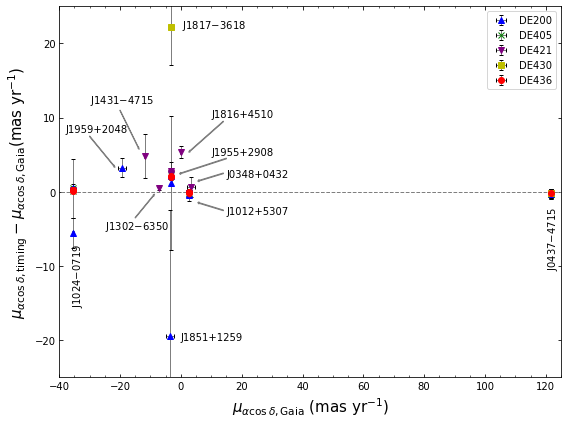

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(pm_tab200["pmra_g"], pm_tab200["dpmra"],
            xerr=pm_tab200["pmra_err_g"],
            yerr=pm_tab200["dpmra_err"],
            fmt="b^",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE200")

ax.errorbar(pm_tab405["pmra_g"], pm_tab405["dpmra"],
            xerr=pm_tab405["pmra_err_g"],
            yerr=pm_tab405["dpmra_err"],
            fmt="gx",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE405")

ax.errorbar(pm_tab421["pmra_g"], pm_tab421["dpmra"],
            xerr=pm_tab421["pmra_err_g"],
            yerr=pm_tab421["dpmra_err"],
            fmt="v",
            color="purple",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE421")

ax.errorbar(pm_tab430["pmra_g"], pm_tab430["dpmra"],
            xerr=pm_tab430["pmra_err_g"],
            yerr=pm_tab430["dpmra_err"],
            fmt="ys",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE430")

ax.errorbar(pm_tab436["pmra_g"], pm_tab436["dpmra"],
            xerr=pm_tab436["pmra_err_g"],
            yerr=pm_tab436["dpmra_err"],
            fmt="ro",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE436")

ax.hlines(0, -50, 250, ls="dashed", color="tab:grey", lw=1)

ax.text(15, 2, "J0348+0432", color="k")
ax.arrow(14, 2.5, -8, -1, width=0.1, color="tab:grey")

ax.text(120, -10, "J0437$-$4715", color="k", rotation="vertical")

ax.text(15, -3, "J1012+5307", color="k")
ax.arrow(14, -2.5, -8, 1, width=0.1, color="tab:grey")

ax.text(-36, -15, "J1024$-$0719", color="k", rotation="vertical")

ax.text(-25, -5, "J1302$-$6350", color="k")
ax.arrow(-15, -3.5, 6, 3, width=0.1, color="tab:grey")

ax.text(-30, 12, "J1431$-$4715", color="k")
ax.arrow(-20, 11, 6, -5, width=0.1, color="tab:grey")

ax.text(10, 10, "J1816+4510", color="k")
ax.arrow(14, 9.5, -11, -4, width=0.1, color="tab:grey")

ax.text(0.4, 22, "J1817$-$3618", color="k")

ax.text(0, -20, "J1851+1259", color="k")

ax.text(10, 5, "J1955+2908", color="k")
ax.arrow(15, 4.5, -15, -2, width=0.1, color="tab:grey")

ax.text(-38, 8, "J1959+2048", color="k")
ax.arrow(-30, 7.5, 8, -4, width=0.1, color="tab:grey")

ax.axis([-40, 125, -25, 25])
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.set_ylabel("$\mu_{\\alpha\cos\delta, {\\rm timing}} - \mu_{\\alpha\cos\delta, {\\rm Gaia}}$(mas yr$^{-1}$)",
              fontsize=15)
ax.set_xlabel("$\mu_{\\alpha\cos\delta, {\\rm Gaia}}$ (mas yr$^{-1}$)",
              fontsize=15)

plt.tight_layout()
plt.legend(loc="upper right")

plt.savefig("../plots/gedr3_pmra-com.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


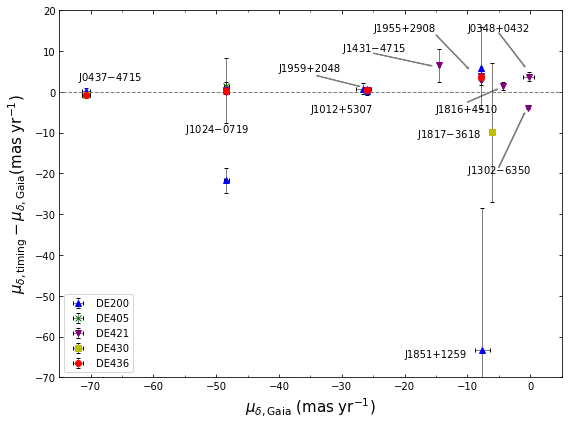

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(pm_tab200["pmdec_g"], pm_tab200["dpmdec"],
            xerr=pm_tab200["pmdec_err_g"],
            yerr=pm_tab200["dpmdec_err"],
            fmt="b^",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE200")

ax.errorbar(pm_tab405["pmdec_g"], pm_tab405["dpmdec"],
            xerr=pm_tab405["pmdec_err_g"],
            yerr=pm_tab405["dpmdec_err"],
            fmt="gx",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE405")

ax.errorbar(pm_tab421["pmdec_g"], pm_tab421["dpmdec"],
            xerr=pm_tab421["pmdec_err_g"],
            yerr=pm_tab421["dpmdec_err"],
            fmt="v",
            color="purple",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE421")

ax.errorbar(pm_tab430["pmdec_g"], pm_tab430["dpmdec"],
            xerr=pm_tab430["pmdec_err_g"],
            yerr=pm_tab430["dpmdec_err"],
            fmt="ys",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE430")

ax.errorbar(pm_tab436["pmdec_g"], pm_tab436["dpmdec"],
            xerr=pm_tab436["pmdec_err_g"],
            yerr=pm_tab436["dpmdec_err"],
            fmt="ro",
            ecolor="k",
            elinewidth=0.5,
            capsize=2,
            label="DE436")

ax.hlines(0, -100, 250, ls="dashed", color="tab:grey", lw=1)
# ax.hlines(1.4, -100, 250, ls="dashed", color="tab:grey", lw=1)
# ax.vlines(-4.4, -100, 250, ls="dashed", color="tab:grey", lw=1)

ax.text(-10, 15, "J0348+0432", color="k")
ax.arrow(-5, 14.5, 4, -8, width=0.1, color="tab:grey")

ax.text(-72, 3, "J0437$-$4715", color="k")

ax.text(-35, -5, "J1012+5307", color="k")

ax.text(-55, -10, "J1024$-$0719", color="k")

ax.text(-10, -20, "J1302$-$6350", color="k")
ax.arrow(-5, -18.5, 4, 13, width=0.1, color="tab:grey")

ax.text(-30, 10, "J1431$-$4715", color="k")
ax.arrow(-25, 9.5, 9, -3, width=0.1, color="tab:grey")

ax.text(-15, -5, "J1816+4510", color="k")
ax.arrow(-10, -2.5, 4.5, 3, width=0.1, color="tab:grey")

ax.text(-18, -11, "J1817$-$3618", color="k")

ax.text(-20, -65, "J1851+1259", color="k")

ax.text(-25, 15, "J1955+2908", color="k")
ax.arrow(-15, 14, 5, -8, width=0.1, color="tab:grey")

ax.text(-40, 5, "J1959+2048", color="k")
ax.arrow(-34, 4, 6.5, -2.5, width=0.1, color="tab:grey")

ax.axis([-75, 5, -70, 20])
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.set_ylabel("$\mu_{\delta, {\\rm timing}} - \mu_{\delta, {\\rm Gaia}}$(mas yr$^{-1}$)",
              fontsize=15)
ax.set_xlabel("$\mu_{\delta, {\\rm Gaia}}$ (mas yr$^{-1}$)",
              fontsize=15)

plt.tight_layout()
plt.legend(loc="lower left")

plt.savefig("../plots/gedr3_pmdec-com.eps")

In [39]:
pm_tab

psr_bname,psr_name,pos_epoch,eph,ra,dec,pmra_t,pmdec_t,plx,ra_err,dec_err,pmra_err_t,pmdec_err_t,plx_err,ref,comment,source_id,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dpmra,dpmdec,dpmra_err,dpmdec_err,X_pmra,X_pmdec
,,d,,,,mas / yr,mas / yr,,,,mas / yr,mas / yr,,,,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0348+0432,J0348+0432,56000.0,DE421,57.18182916666666,4.536516111111111,4.04,3.5,0.0,0.05981202763317285,0.2,0.16,0.6000000000000001,0.0,afw+13,,3273288485744249344,3.438,1.345,-0.226,0.887,0.6019999999999999,3.726,1.354483296316348,1.0708730083441267,0.44444992539752887,3.4794041599399845
J0437-4715,J0437-4715,54500.0,DE421,69.3162340571,-47.2525307528,121.439,-71.475,6.373,0.00602974,0.00626552,0.001915,0.001954,0.086288,rhc+16,PPTA-DR1e,4789864076732331648,121.646,0.574,-70.697,0.65,-0.20700000000000784,-0.7779999999999916,0.5740031944379752,0.6500029370056724,-0.36062517074088435,-1.1969176686861682
J0437-4715,J0437-4715,57600.0,DE430,69.316656,-47.252699166666666,121.48,-71.43,0.0,0.10181492269904993,0.1,0.02,0.01,0.0,jbs+19,UTMOST-I,4789864076732331648,121.646,0.574,-70.697,0.65,-0.16599999999999682,-0.7330000000000041,0.5743483263665004,0.6500769185258003,-0.28902321531980874,-1.1275588766668583
J0437-4715,J0437-4715,54500.0,DE421,69.3162340617,-47.2525307528,121.441,-71.475,6.441,0.00373391,0.00383898,0.001714,0.001865,0.074791,vlh+16,IPTA-DR1,4789864076732331648,121.646,0.574,-70.697,0.65,-0.2049999999999983,-0.7779999999999916,0.5740025590500446,0.6500026755521857,-0.3571412649087603,-1.1969181501277213
J0437-4715,J0437-4715,53019.0,DE405,69.31603281125,-47.252450716666665,121.31,-71.53,0.0,0.008145232028164005,0.008,0.01,0.01,0.0,hbo06,,4789864076732331648,121.646,0.574,-70.697,0.65,-0.3359999999999985,-0.8329999999999984,0.5740871014053529,0.6500769185258003,-0.5852770410230046,-1.2813868270988893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B1953+29,J1955+2908,54500.0,DE405,298.86615,29.145407194444445,-0.9,-4.1,0.0,0.3930239364478579,0.5,0.1,0.1,0.0,gsf+11,,2028584968839606784,-3.167,0.135,-7.827,0.167,2.267,3.7270000000000003,0.16800297616411444,0.1946509696867704,13.493808572685468,19.14709187422717
B1953+29,J1955+2908,55000.0,DE436,298.8661490629,29.1454053639,-1.029,-4.171,-1.178,0.17596624,0.24031268,0.055342,0.078402,1.098837,pdd+19,IPTA-DR2,2028584968839606784,-3.167,0.135,-7.827,0.167,2.138,3.6559999999999997,0.14590317667549257,0.1844881394670129,14.653553464124958,19.816992087199758


In [40]:
for i in range(len(pm_tab)):
    
    if pm_tab[i]["pmra_err_t"] < pm_tab[i]["pmra_err_g"]:
        print("PMRA")
        print(pm_tab["psr_name"][i], pm_tab["pmra_t"][i], pm_tab["pmra_err_t"][i], pm_tab["pmra_g"][i], pm_tab["pmra_err_g"][i]) 
    
    if pm_tab[i]["pmdec_err_t"] < pm_tab[i]["pmdec_err_g"]:
        print("PMDEC")
        print(pm_tab["psr_name"][i], pm_tab["pmdec_t"][i], pm_tab["pmdec_err_t"][i], pm_tab["pmdec_g"][i], pm_tab["pmdec_err_g"][i]) 
    

PMRA
J0348+0432 4.04 0.16 3.438 1.345
PMDEC
J0348+0432 3.5 0.6000000000000001 -0.226 0.887
PMRA
J0437-4715 121.439 0.001915 121.646 0.574
PMDEC
J0437-4715 -71.475 0.001954 -70.697 0.65
PMRA
J0437-4715 121.48 0.02 121.646 0.574
PMDEC
J0437-4715 -71.43 0.01 -70.697 0.65
PMRA
J0437-4715 121.441 0.001714 121.646 0.574
PMDEC
J0437-4715 -71.475 0.001865 -70.697 0.65
PMRA
J0437-4715 121.31 0.01 121.646 0.574
PMDEC
J0437-4715 -71.53 0.01 -70.697 0.65
PMRA
J0437-4715 121.3 0.2 121.646 0.574
PMDEC
J0437-4715 -70.4 0.30000000000000004 -70.697 0.65
PMRA
J0437-4715 121.443 0.001435 121.646 0.574
PMDEC
J0437-4715 -71.474 0.00156 -70.697 0.65
PMRA
J1012+5307 2.66 0.03 2.736 0.292
PMDEC
J1012+5307 -25.5 0.04 -25.921 0.271
PMRA
J1012+5307 2.627 0.010222 2.736 0.292
PMDEC
J1012+5307 -25.458 0.013951 -25.921 0.271
PMRA
J1012+5307 2.614 0.010224 2.736 0.292
PMDEC
J1012+5307 -25.486 0.013773 -25.921 0.271
PMRA
J1012+5307 2.562 0.014 2.736 0.292
PMDEC
J1012+5307 -25.61 0.02 -25.921 0.271
PMRA
J1012+5307 2.5